In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import pickle
from typing import List, Optional, _TypedDict
import numpy as np
import pandas as pd
import os
from scipy.sparse import csr_matrix
from src.utils import load_checkpoint
from src.features.main import summarize_matrix

df = load_checkpoint("src/extract/dataframe_checkpoint_20.pickle")

Loading checkpoint from src/extract/dataframe_checkpoint_20.pickle
Loaded 19262 rows and 3 columns.


In [ ]:
from src.features.manual_string_extraction import manual_string_extraction

print("Creating manual string feature matrix...")
man_str_matrix, features = manual_string_extraction(df)
summarize_matrix(man_str_matrix, features)

Creating manual string feature matrix...
Matrix shape: (19262, 102)
Nonzero elements: 544343
First 10 feature names: ['line_count', 'char_count', 'chars_per_line', 'blank_line_ratio', 'comment_ratio', 'doc_density', 'cyclomatic_complexity', 'condition_count', 'loop_count', 'condition_density']


c:\Users\boden\Documents\Coding\classifier\.venv\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
c:\Users\boden\Documents\Coding\classifier\.venv\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
c:\Users\boden\Documents\Coding\classifier\.venv\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
c:\Users\boden\Documents\Coding\classifier\.venv\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuo

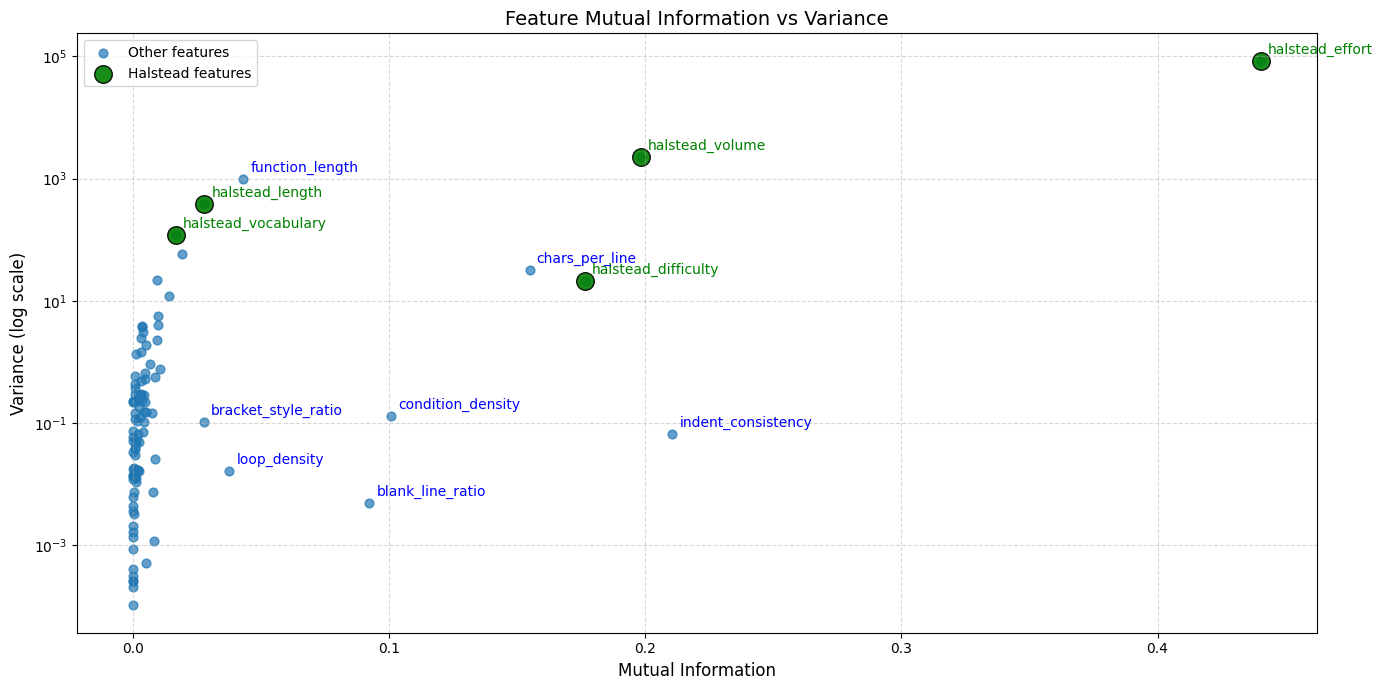


Number of features with variance = 0: 4


In [ ]:
import matplotlib.pyplot as plt
from src.features.feature_selection import analyze_feature_mutual_info, analyze_feature_variance

mi = analyze_feature_mutual_info(man_str_matrix, df["target"].values, features)
v = analyze_feature_variance(man_str_matrix, features)

mi_sorted = mi.sort_values("mutual_info", ascending=False).reset_index(drop=True)

# Merge mutual info and variance on feature name
mi_var = pd.merge(mi_sorted, v, on="feature", how="inner")

# Identify Halstead features for special styling
halstead_features = [
    "halstead_effort", "halstead_volume", "halstead_difficulty",
    "halstead_length", "halstead_vocabulary"
]
is_halstead = mi_var["feature"].isin(halstead_features)

# Identify features with mutual_info > 0.02 for labeling
label_mask = mi_var["mutual_info"] > 0.02

fig, ax = plt.subplots(figsize=(14, 7))
# Plot all features
ax.scatter(
    mi_var["mutual_info"], mi_var["variance"],
    s=40, c="#1f77b4", label="Other features", alpha=0.7
)
# Highlight Halstead features
ax.scatter(
    mi_var.loc[is_halstead, "mutual_info"],
    mi_var.loc[is_halstead, "variance"],
    s=160, c="green", label="Halstead features", edgecolor="black", alpha=0.9
)
# Annotate Halstead features
for _, row in mi_var[is_halstead].iterrows():
    ax.annotate(row["feature"], (row["mutual_info"], row["variance"]),
                textcoords="offset points", xytext=(5,5), ha='left', fontsize=10, color="green")
# Annotate features with mutual_info > 0.2 (except Halstead, to avoid duplicate labels)
for _, row in mi_var[label_mask & ~is_halstead].iterrows():
    ax.annotate(row["feature"], (row["mutual_info"], row["variance"]),
                textcoords="offset points", xytext=(5,5), ha='left', fontsize=10, color="blue")

ax.set_title("Feature Mutual Information vs Variance", fontsize=14)
ax.set_xlabel("Mutual Information", fontsize=12)
ax.set_ylabel("Variance (log scale)", fontsize=12)
ax.set_yscale("log")
ax.grid(axis='both', linestyle='--', alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()

print("\nNumber of features with variance = 0:", len(v[v["variance"] == 0]))


In [ ]:
from src.features.feature_selection import trim_features_by_mutual_info, trim_features_by_variance

print("\nTrimming features...")

# Initial features list
current_features = list(features) # Make a copy if 'features' shouldn't be modified

# First trim by Mutual Information
man_str_matrix_mi_trimmed, mi_features = trim_features_by_mutual_info(
    man_str_matrix,
    df["target"].values,
    current_features,
    0.01
)

print(f"Features kept after MI trimming: {len(mi_features)}")

# Update the matrix and the current list of features for the next step
man_str_matrix_current = man_str_matrix_mi_trimmed
current_features = mi_features

# Second trim by Variance
man_str_matrix_v_trimmed, v_features = trim_features_by_variance(
    man_str_matrix_current,
    current_features,
    0.001
)

print(f"Features kept after Variance trimming: {len(v_features)}")
print(f"Final trimmed features: {v_features}")


Trimming features...
Features kept after MI trimming: 15
Features kept after Variance trimming: 15
Final trimmed features: ['line_count', 'char_count', 'chars_per_line', 'blank_line_ratio', 'comment_ratio', 'doc_density', 'cyclomatic_complexity', 'condition_count', 'loop_count', 'condition_density', 'loop_density', 'max_nesting_depth', 'return_count', 'goto_count', 'switch_count']


c:\Users\boden\Documents\Coding\classifier\.venv\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
c:\Users\boden\Documents\Coding\classifier\.venv\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
c:\Users\boden\Documents\Coding\classifier\.venv\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
c:\Users\boden\Documents\Coding\classifier\.venv\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuo

In [1]:
print("\nSaving string-based manual extraction matrix...")
output_path = os.path.join("src", "features", "matrices", "matrix_man-str.pickle")
with open(output_path, "wb") as f:
    pickle.dump(man_str_matrix, f)
print(f"Saved matrix to {output_path}")


Saving string-based manual extraction matrix...


NameError: name 'os' is not defined